<a href="https://colab.research.google.com/github/mirpouya/Transformers-in-Computer-Vision/blob/main/Implement_basic_ViT_from_scratch_with_CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00


In [29]:
import torch
from torch import nn, Tensor
from einops.layers.torch import Rearrange
from einops import rearrange
from einops import repeat
from torchvision.datasets import CIFAR100
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

In [3]:
# basic image transformation preprocessing

transforms = [Resize((144, 144)), ToTensor()]

class Compose(object):
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, image):
    for transform in self.transforms:
      image = transform(image)

    return image

In [4]:
# visualize images in dataset

def show_images(dataset, n_samples=40, cols=8):

  plt.figure(figsize=(16, 16))
  idx = int(len(dataset)/n_samples)
  print(f"images: {dataset}")

  for i, img in enumerate(dataset):
    if i % idx == 0:
      plt.subplot(int(n_samples/cols) + 1, cols, int(i/idx) + 1)
      plt.imshow(to_pil_image(img[0]))

In [5]:
to_tensor = [Resize((144, 144)), ToTensor()]

In [6]:
# downloading the dataset

dataset = CIFAR100(download=True, root=".", transform=Compose(to_tensor))

100%|██████████| 169001437/169001437 [00:02<00:00, 62461572.20it/s]


Extracting ./cifar-100-python.tar.gz to .


images: Dataset CIFAR100
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: <__main__.Compose object at 0x7ddbcd34b370>


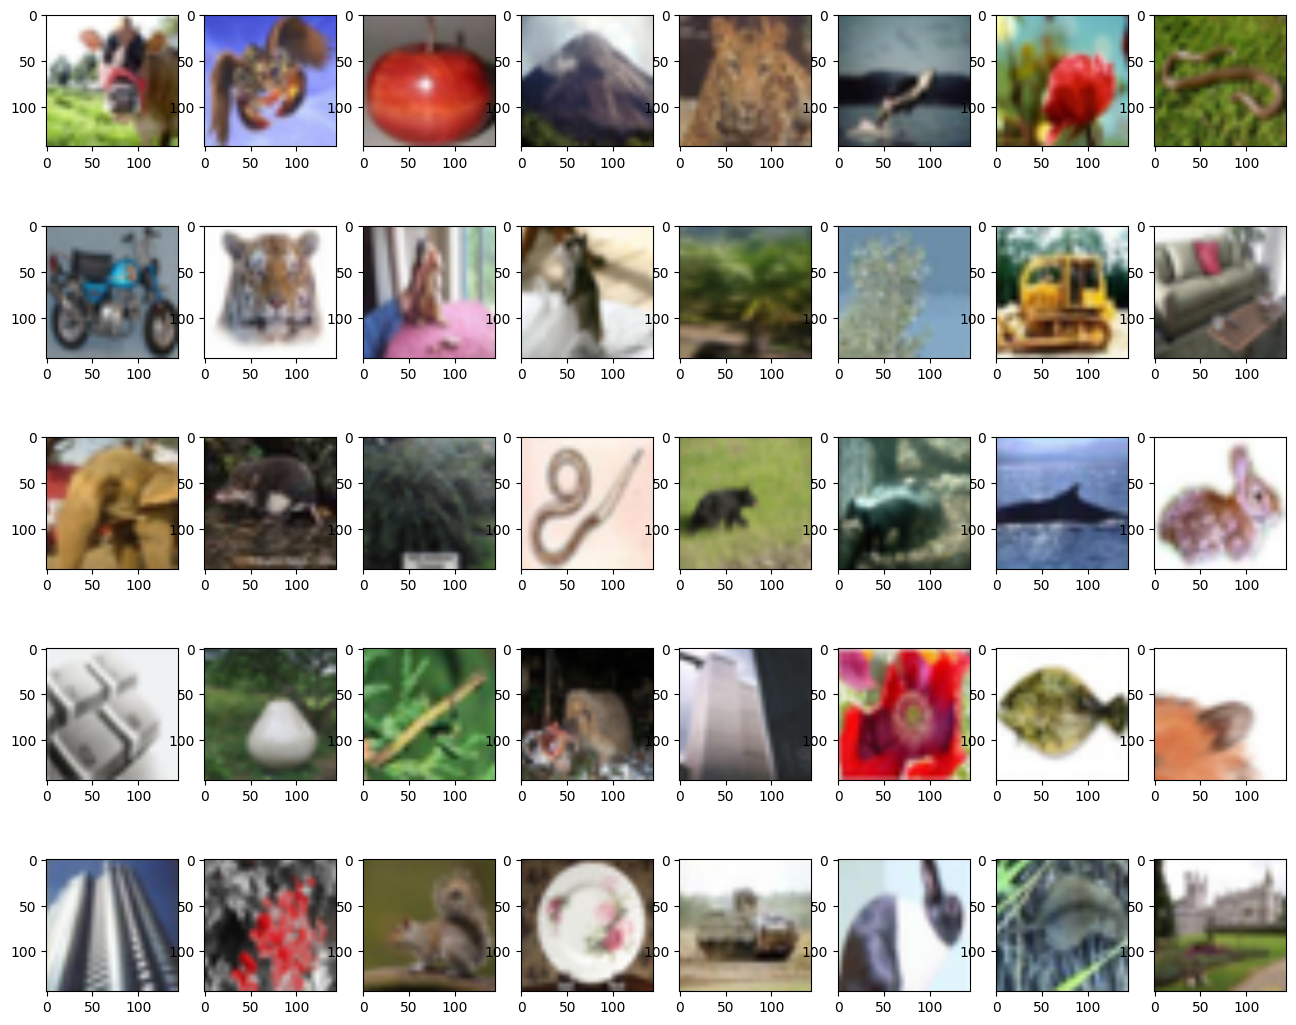

In [7]:
show_images(dataset)

In [8]:
dataset

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: <__main__.Compose object at 0x7ddbcd34b370>

In [9]:
len(dataset.classes)

100

In [10]:
# Initialize a dictionary to store the count of samples for each class
class_counts = {label: 0 for label in dataset.classes}

# Iterate through the dataset to count the number of samples for each class
for _, label in dataset:
    class_counts[dataset.classes[label]] += 1

# Print the count of samples for each class
for label, count in class_counts.items():
    print(f"Class '{label}' has {count} samples.")

Class 'apple' has 500 samples.
Class 'aquarium_fish' has 500 samples.
Class 'baby' has 500 samples.
Class 'bear' has 500 samples.
Class 'beaver' has 500 samples.
Class 'bed' has 500 samples.
Class 'bee' has 500 samples.
Class 'beetle' has 500 samples.
Class 'bicycle' has 500 samples.
Class 'bottle' has 500 samples.
Class 'bowl' has 500 samples.
Class 'boy' has 500 samples.
Class 'bridge' has 500 samples.
Class 'bus' has 500 samples.
Class 'butterfly' has 500 samples.
Class 'camel' has 500 samples.
Class 'can' has 500 samples.
Class 'castle' has 500 samples.
Class 'caterpillar' has 500 samples.
Class 'cattle' has 500 samples.
Class 'chair' has 500 samples.
Class 'chimpanzee' has 500 samples.
Class 'clock' has 500 samples.
Class 'cloud' has 500 samples.
Class 'cockroach' has 500 samples.
Class 'couch' has 500 samples.
Class 'crab' has 500 samples.
Class 'crocodile' has 500 samples.
Class 'cup' has 500 samples.
Class 'dinosaur' has 500 samples.
Class 'dolphin' has 500 samples.
Class 'elep

<h2> <b> Patch Embedding </b> </h2>

In [11]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels=3, patch_size=8, embed_size=128):
    super().__init__()
    self.patch_size = patch_size

    # rearanging images into patches
    self.projection = nn.Sequential(
        # (3 * 128 * 128) -> (3 * (16 * 16) * (8 * 8))
        # for example a 28*128 image into 16*16 patches of 8*8 size
        # [batch_size, channels, height_sections * patch_size, width_sections * patch_size] ->
        # [batch_size, (height_sections, width_sections) * (patch_size, patch_size, channels)]
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
        nn.Linear(patch_size * patch_size * in_channels, embed_size)
    )

  def forward(self, x: Tensor) -> Tensor:
    x = self.projection(x)
    return x

In [12]:
# testing PatchEmbedding class
sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
print("Initial shape: ", sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)

Initial shape:  torch.Size([1, 3, 144, 144])
Patches shape:  torch.Size([1, 324, 128])


explain where does 324 come from

In [13]:
Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)(torch.unsqueeze(dataset[0][0], 0)).shape

torch.Size([1, 324, 192])

<h1> <b> ViT Model </b> </h1>

In [18]:
# Attention module

class Attention(nn.Module):
  def __init__(self, dim, n_heads, dropout=0.):
    super().__init__()
    self.attention_module = nn.MultiheadAttention(embed_dim = dim,
                                       num_heads = n_heads,
                                       dropout = dropout)

    self.q = nn.Linear(dim, dim)
    self.k = nn.Linear(dim, dim)
    self.v = nn.Linear(dim, dim)

  def forward(self, x):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)
    attention_output, attention_output_weights = self.attention_module(q, k, v)

    return attention_output

In [19]:
# testing attention module
Attention(dim=128, n_heads=4, dropout=0.2)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [21]:
Attention(dim=100, n_heads=4, dropout=0.2)(torch.ones((1, 5, 100))).shape

torch.Size([1, 5, 100])

<h2> <b> Layer Normalization </b> </h2>

In Attention mechanism, Normalization is not the conventional batch norm, but it is layer normalization.

In [22]:
# this block recieves a function, and applies the layer norm to the input of that function, before the function applies

class PreNorm(nn.Module):
  def __init__(self, dim, func):
    super().__init__()
    self.layer_norm = nn.LayerNorm(dim)
    self.func = func

  def forward(self, x, **kwargs):
    return self.func(self.layer_norm(x), **kwargs)

In [23]:
# testing dimensionality

norm = PreNorm(dim = 128, func = Attention(dim=128, n_heads=4, dropout=0.1))
norm(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

<h2> <b> Feed Forward or Linear head </b> <h2>

In [24]:
class FeedForward(nn.Sequential):
  def __init__(self, dim, hidden_dim, dropout=0.):
    super().__init__(
        nn.Linear(dim, hidden_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, dim),
        nn.GELU(),
        nn.Dropout(dropout))

In [25]:
# testing dimensionality
FeedForward(dim=128, hidden_dim=256, dropout=0.15)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

<h2> <b> Residual Block </b> </h2>

The input befor normalization, adds to the output of attention module

In [27]:
class ResidualAdd(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, x, **kwargs):
    res = x
    x = self.func(x, **kwargs)
    return (res + x)

In [28]:
# testing dimensionality

ResidualAdd(Attention(dim=128, n_heads=4, dropout=0.1))(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

<h1> <b> Vision Transform Model </b> </h1>
<h3> Put all things together </h3>

In [49]:
class ViT(nn.Module):
  def __init__(self, n_channels=3, im_size=144, patch_size=4,
               embed_dim=32, n_layers=6, out_dim=37, dropout=0.1, heads=2):
    super(ViT, self).__init__()

    # Attributes
    self.n_channels = n_channels
    self.im_width = im_size
    self.im_height = im_size
    self.patch_size = patch_size
    self.n_layers = n_layers

    # Patching
    self.patch_embedding = PatchEmbedding(patch_size=patch_size, embed_size=embed_dim, in_channels=n_channels)

    # Learnable parameters
    num_patches = (im_size // patch_size) ** 2
    self.position_embedding = nn.Parameter(torch.randn(1, num_patches+1, embed_dim))
    self.cls_tocken = nn.Parameter(torch.randn(1, 1, embed_dim))

    # Transformer Encoder
    self.encoder_layers = nn.ModuleList([])   # for forward computation

    for _ in range(n_layers):
      transformer_encod_block = nn.Sequential(
          ResidualAdd(PreNorm(dim=embed_dim, func=Attention(dim=embed_dim, n_heads=heads, dropout=dropout))),
          ResidualAdd(PreNorm(dim=embed_dim, func=FeedForward(dim=embed_dim, hidden_dim=embed_dim, dropout=dropout)))
        )
      self.encoder_layers.append(transformer_encod_block)

    # classification head
    self.classification_head = nn.Sequential(
        nn.LayerNorm(embed_dim),
        nn.Linear(embed_dim, out_dim)
    )

  def forward(self, img):
    # Get patch embedding vectors
    x = self.patch_embedding(img)
    b, n, _ = x.shape

    # Add cls token to inputs
    cls_tocken = repeat(self.cls_tocken, '1 1 d -> b 1 d', b = b)
    x = torch.cat([cls_tocken, x], dim=1)
    x += self.position_embedding[:, :(n + 1)]

    # Transformer layers
    for i in range(self.n_layers):
        x = self.encoder_layers[i](x)

    # Output based on classification token
    return self.classification_head(x[:, 0, :])

In [50]:
vit_model = ViT()
print(vit_model)

ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): ResidualAdd(
        (func): PreNorm(
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (func): Attention(
            (attention_module): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (func): PreNorm(
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (func): FeedForward(
        

In [41]:
!pip install torchsummary

In [51]:
from torchsummary import summary

# Specify the input shape (batch_size, channels, height, width)
# For example, if your input images have a size of 3x144x144
input_shape = (3, 144, 144)

# Print the summary of the model
summary(vit_model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1             [-1, 1296, 48]               0
            Linear-2             [-1, 1296, 32]           1,568
    PatchEmbedding-3             [-1, 1296, 32]               0
         LayerNorm-4             [-1, 1297, 32]              64
            Linear-5             [-1, 1297, 32]           1,056
            Linear-6             [-1, 1297, 32]           1,056
            Linear-7             [-1, 1297, 32]           1,056
MultiheadAttention-8  [[-1, 1297, 32], [-1, 2, 2]]               0
         Attention-9             [-1, 1297, 32]               0
          PreNorm-10             [-1, 1297, 32]               0
      ResidualAdd-11             [-1, 1297, 32]               0
        LayerNorm-12             [-1, 1297, 32]              64
           Linear-13             [-1, 1297, 32]           1,056
             GELU-14             [-1